# Reinforcement Learning Notes 2

(An edited write-up is [on my blog](https://krisztiankovacs.com/rl-notes-2/))

This week was all about two tools to solve MDPs: **policy iteration** and **value iteration**. Both of them are applications of the Bellman equation. However, here I will try to explain both without any math, and without any Bellman equations.
    
## Frozen Lake

The example I'll use is the frozen lake environment of Openai.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import gym
import matplotlib.pyplot as plt

import utils_fl

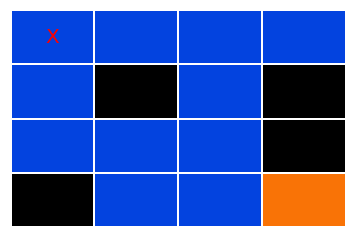

In [2]:
env = gym.make('FrozenLake-v0')
utils_fl.env2img(env, 'start_pos')

It is a similar gridworld to the one covered [last week](https://krisztiankovacs.com/reinforcement_learning/2018/09/19/rl-notes-1.html). We start at the top left (at the X), and try to move to the orange square in the bottom right, where we get our reward of + 1 and the game ends. If we move to a black square, we fall into a hole: the game ends without a reward.

There is one important complication: as we move on the blue tiles, we might slip to the side, and end up in a tile different from the one we intended. There is a 33% chance that we move correctly, and a 33% chance for landing in either side. For example, if we want to move down, we might slip to the left or to the right. We never slip to the opposite direction of our action though. 

As mentioned above, there two ways to solve this game.

# Value Iteration

Our goal here is to find the state value function under optimal policy. That means each square will be assigned a number, representing its 'value'. Once we have that, finding the optimal policy will be easy.

How do we find the state value function? We work iteratively. We first initialize all values to 0. We then find then optimal action for each tile. The optimal action is the one that maximizes the expected return (the immediate reward + discounted future value). Once we have that, we assign to the tile the expected return. We iterate until the state value function converges.

To make our agent prefer shorter paths (i.e. finish the game earlier than later), we set a discount factor of 99%.

In [3]:
GAMMA = 0.99

In [4]:
def getExpectedActionValue(s, a, V, env, g): 
    '''Gives expected return of action "a" in state "s" (immediate reward + discounted future value)'''
    return sum(prob*(reward + g*V[state]) for prob, state, reward, _ in env.env.P[s][a])

def getOptimalFromState(s, V, env, g):
    '''Gives the best possible return in state "s" from all actions'''
    vals = np.array([getExpectedActionValue(s, a, V, env, g) for a in env.env.P[s].keys()])
    return (vals.max(), vals.argmax())

def getNextV(V, env, g, pi = None):
    '''Gives the next iteration of the value function.'''
    res = np.zeros(V.shape)
    for s in range(env.env.nS):
        if pi is None:
            res[s], _ = getOptimalFromState(s, V, env, g)
        else:
            res[s] = getExpectedActionValue(s, pi[s], V, env, g)
    return res

For example, here are the first three iterations of our state value function:

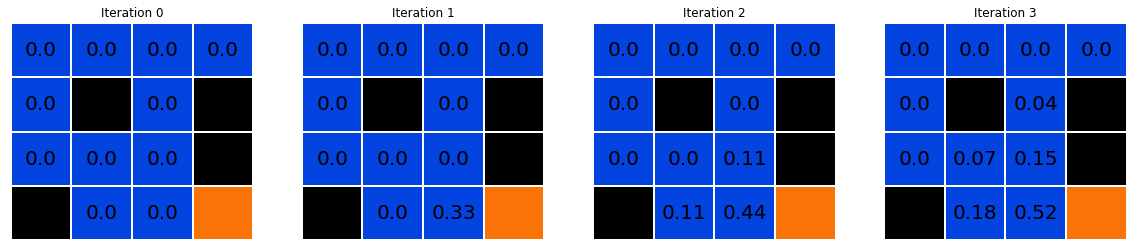

In [5]:
f = plt.figure(figsize = (20, 4))
V = np.zeros(env.env.nS)

for i in range(4):
    ax = f.add_subplot(1, 4, i+1)
    ax.set_title(f'Iteration {i}')
    utils_fl.plotV(V, env)
    V = getNextV(V, env, GAMMA)

We do this process until our value function converges. 

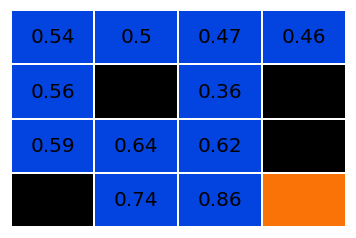

In [6]:
def ValueIter(env, g, pi = None, eps = 1e-10, maxiter = 10000):
    
    '''Applies value iteration if pi = None. If pi (policy) is given, it applies policy evaluation'''
    
    V = np.zeros(env.env.nS); flag_success = False 
    
    for i in range(maxiter):
        V_old = V.copy()
        V = getNextV(V, env, g, pi)
        
        if np.max(np.abs(V - V_old)) < eps:
            flag_success = True
            break
    assert flag_success
    
    return (V, i)

V_value_iter, _ = ValueIter(env, g = GAMMA)
utils_fl.plotV(V_value_iter, env)

Let's do a check. Suppose we are on third row, second column (value 0.64). What's our best action? To move down, obviously. With 33% we end up left or right. What is our return? $0.99 * \frac{1}{3}*(0.62 +0.74 +0.59) = 0.64$. It checks out.

Now, let's get our optimal policy. As a reminder, a policy is an action for every square. It's easy to find it: for every square let's look at what would maximize our return according to the state value function we derived.

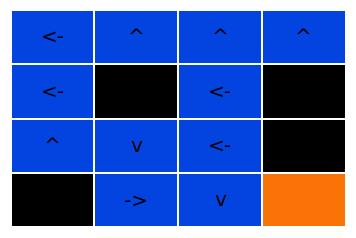

In [7]:
def getPath(V, env, g):
    '''Gets the optimal path according to state-value function V.'''
    path = np.zeros(env.env.nS)
    for s in range(env.env.nS):
        _, path[s] = getOptimalFromState(s, V, env, g)
    return path

path_value_iter = getPath(V_value_iter, env, 1)
utils_fl.plotPath(path_value_iter, env)

(For those wondering why we move 'left' at the start: because if we do, the only movement we can take is 'slipping' down.)

## Policy Iteration

A second way to solve MDPs is policy iteration. 

We start with an arbitrary policy. In this example, I'll choose to always move right.

Next we do a policy evaluation step: calculating the state value function under the given policy. As a reminder, the value of a state under a policy is the immediate reward + discounted value of the state we end up in. We iteratively update our value function until it converges, just as in the previous section. The key difference: we choose our action based on the given policy (not the optimal one).

Policy evaluation gives us a state value function. For example, here is the value function for always moving to the right:

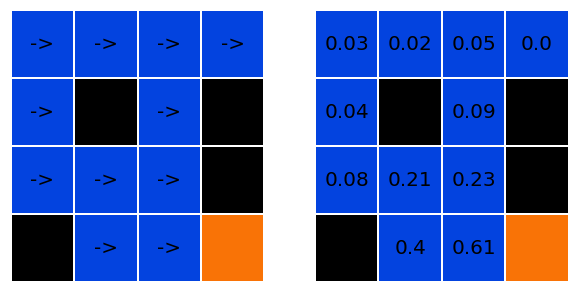

In [8]:
pi_start = np.array([2 for i in range(env.env.nS)])
V, _ = ValueIter(env, GAMMA, pi_start)

utils_fl.plotPathAndV(pi_start, V, env)

Now we change our policy according to this value function. That gives us a new policy.

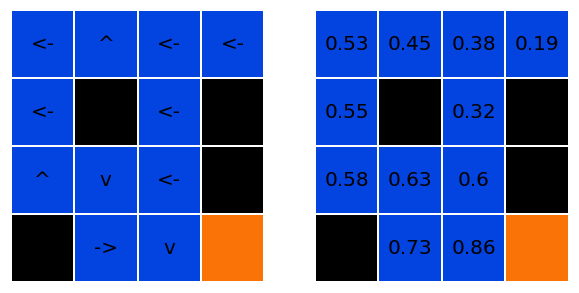

In [9]:
pinew = getPath(V, env, GAMMA)
V, _ = ValueIter(env, GAMMA, pinew)

utils_fl.plotPathAndV(pinew, V, env)

To summarize, our process looks like this:

initial policy -> policy evaluation -> policy improvement -> policy evaluation -> policy improvement -> ... 

We keep on repeating this process until convergence.

In [10]:
def policyIter(env, g, maxiter = 1000):
    
    '''Finds optimal policy using policy iteration.'''
    
    # Start by always going to the right
    pi = np.array([2 for i in range(env.env.nS)])
    flag_success = False
    
    for i in range(maxiter):
        pi_old = pi.copy()
        V, _ = ValueIter(env, g, pi)  # Policy evaluation step
        pi = getPath(V, env, g)  # Policy Improvement step
        if np.all(pi == pi_old):
            flag_success = True
            break
            
    assert flag_success
    return (pi, V)  

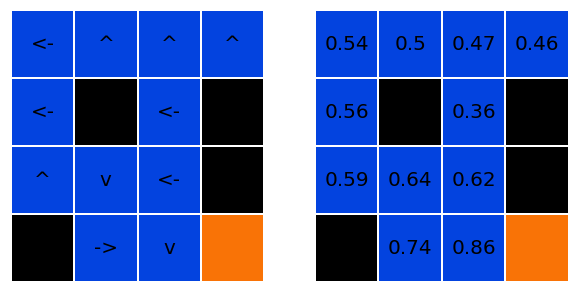

In [11]:
path_pol_iter, V_pol_iter = policyIter(env, GAMMA)
utils_fl.plotPathAndV(path_pol_iter, V_pol_iter, env)

## Comparing Value and Policy Iteration

Do they give the same policy? Yes, they do.

In [12]:
all(path_pol_iter == path_value_iter)

True

What about runtime? In our example, policy iteration is somewhat faster: 180 ms vs 280 ms.

In [13]:
%%time
path, V = policyIter(env, 1)

CPU times: user 163 ms, sys: 8.57 ms, total: 172 ms
Wall time: 158 ms


In [14]:
%%time
V, _ = ValueIter(env, 1)
path = getPath(V, env, 1)

CPU times: user 331 ms, sys: 25.4 ms, total: 357 ms
Wall time: 323 ms


What reward do would our policy get in the game? Since not all games are won, the outcome is random. On average, our reward is about 0.75, which is equivalent to getting to the target cell about 75% of the time.

In [15]:
def runPolicy(policy, maxiter = 1000, do_render = True, env_name = 'FrozenLake-v0'):
    temp_env = gym.make(env_name)
    s = temp_env.reset()
    cum_reward = 0
    for k in range(maxiter):
        if do_render: 
            temp_env.render()
        s, r, done, _ = temp_env.step(int(policy[s]))
        cum_reward += r
        if done:
            break
    if do_render: 
        temp_env.close()
    return cum_reward

def simAvgReward(policy, iterations = 1000, env_name = 'FrozenLake-v0'):
    totalRewards = 0
    for i in range(iterations):
        totalRewards += runPolicy(policy, do_render=False, env_name=env_name)
    print(f'Average Return from {iterations} simulations is {totalRewards / iterations}')
    return None

simAvgReward(path_value_iter)

Average Return from 1000 simulations is 0.754


We can visualize the outcome of a single run with the following:

In [1]:
# runPolicy(path_value_iter)

## Frozen Lake 8x8

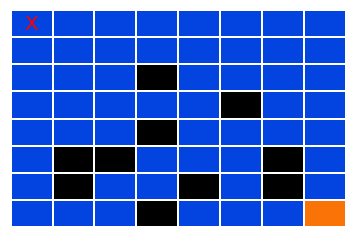

In [17]:
env = gym.make('FrozenLake8x8-v0')
utils_fl.env2img(env, 'start_pos')

This setting seems to have a very uninteresting solution: just walk on the top and on the right! Let's see if my intuition is correct. Let's apply no discounting, so our agent doesn't care how long his path takes.

In [18]:
pol_8x8, V_8x8 = policyIter(env, g = 1)

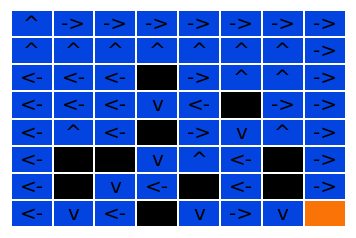

In [19]:
utils_fl.plotPath(pol_8x8, env)

In [20]:
simAvgReward(pol_8x8, env_name='FrozenLake8x8-v0')

Average Return from 1000 simulations is 0.895


We don't achieve perfect reward, because frozenlake caps the number of time-steps at 200. So in the cases we lost, we simply wandered for 200 steps without falling into a hole or getting the reward.